In [112]:
import sys

sys.path.append("../")

import MetaTrader5 as mt5
import pytz
import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from terminal.Extensions.MT5 import MT5

In [113]:
MT5.initialize()

In [222]:
slippage = 0.5

from_date = datetime(2024, 6, 5, tzinfo=pytz.utc)
to_date = datetime(2024, 6, 6, tzinfo=pytz.utc)

ticks = None

while from_date < to_date:
    range = mt5.copy_ticks_range(
        "PETR4", from_date, from_date.replace(hour=23), mt5.COPY_TICKS_TRADE
    )
    if mt5.last_error()[0] == mt5.RES_S_OK:
        if ticks is None:
            ticks = range
        else:
            ticks = np.append(ticks, range, axis=0)
    from_date += timedelta(days=1)

In [223]:
all_trades = MT5.create_ticks_dataframe(ticks)
bulls_trades = all_trades[(all_trades["flags"] & mt5.TICK_FLAG_BUY == mt5.TICK_FLAG_BUY)]
bears_trades = all_trades[(all_trades["flags"] & mt5.TICK_FLAG_SELL == mt5.TICK_FLAG_SELL)]

,open,high,low,close,tick_volume,real_volume,vwap
open,1.000000,0.989058,0.988350,0.980514,-0.006952,-0.021233,0.936948
high,0.989058,1.000000,0.983450,0.988141,0.039423,-0.004813,0.935291
low,0.988350,0.983450,1.000000,0.987714,-0.071225,-0.041252,0.935769
close,0.980514,0.988141,0.987714,1.000000,-0.016712,-0.024751,0.930855
tick_volume,-0.006952,0.039423,-0.071225,-0.016712,1.000000,0.588465,0.000698
real_volume,-0.021233,-0.004813,-0.041252,-0.024751,0.588465,1.000000,-0.020889
vwap,0.936948,0.935291,0.935769,0.930855,0.000698,-0.020889,1.000000


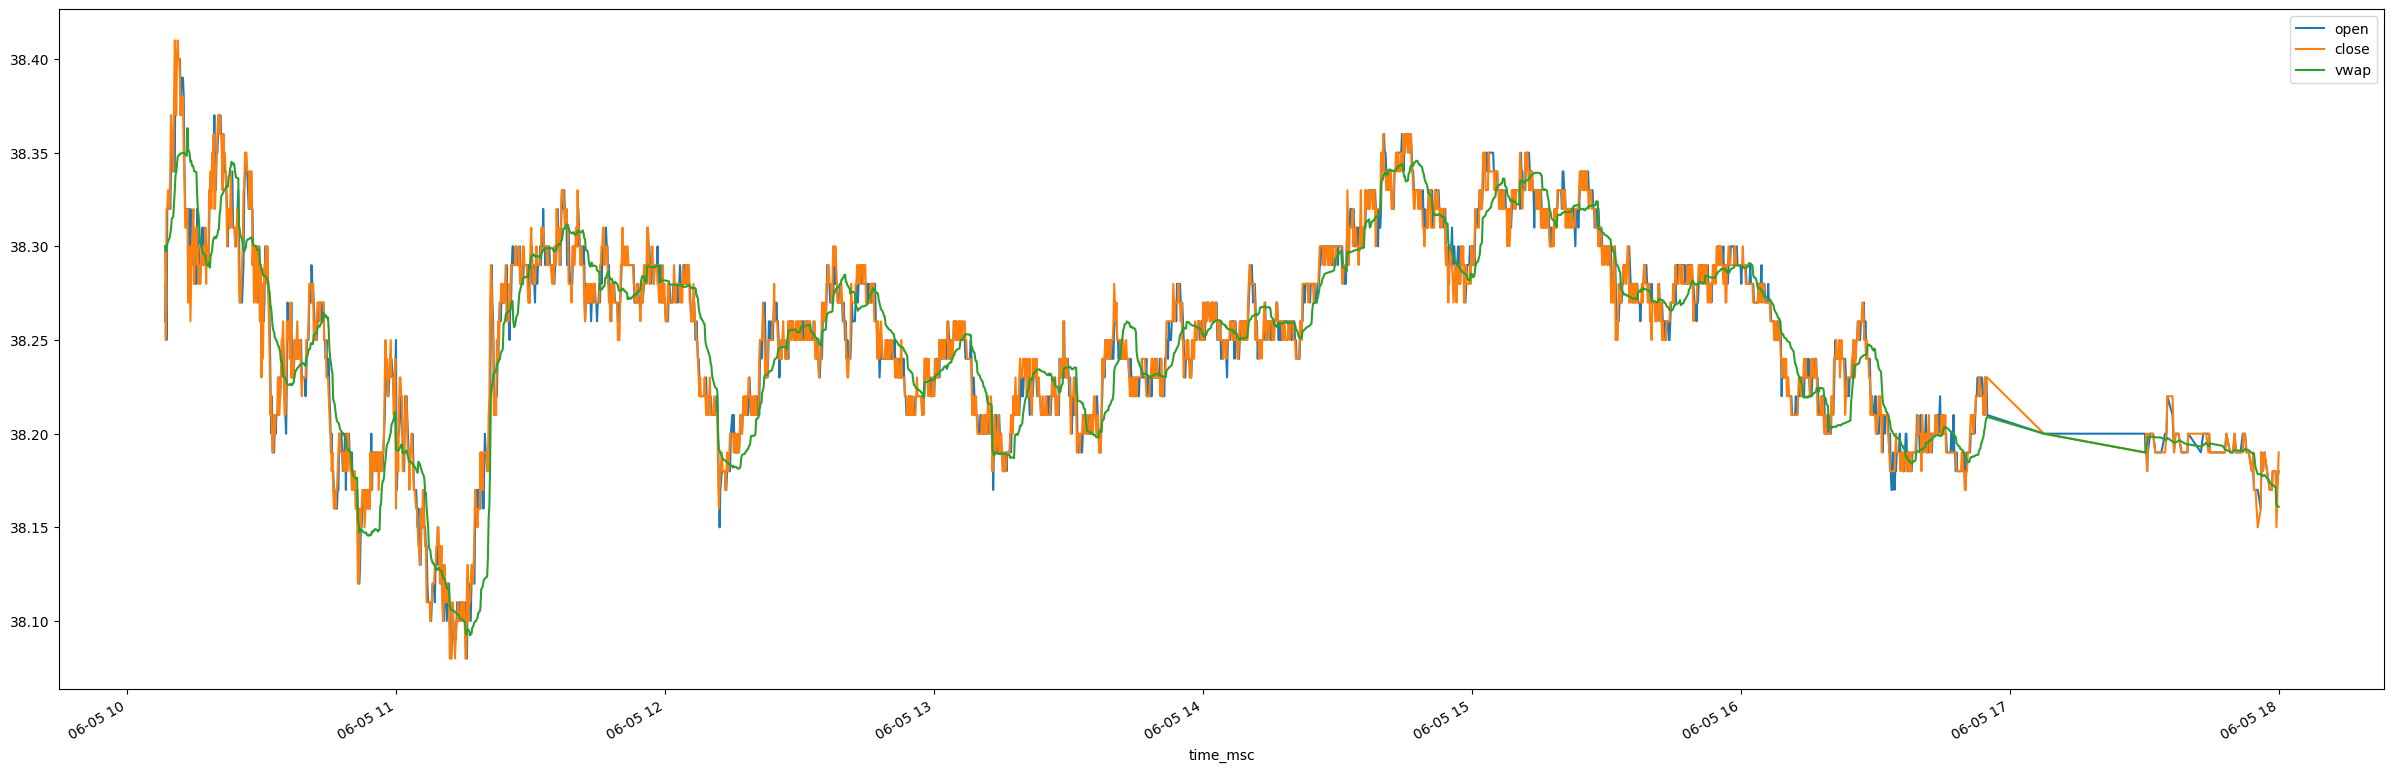

In [226]:
timeframe = "10s"

ratesjoin = MT5.create_ohlc_from_ticks(all_trades, timeframe)

vwap_window = "5min"

ratesjoin["vwap"] = (ratesjoin["close"] * ratesjoin["real_volume"]).rolling(vwap_window).sum() / ratesjoin["real_volume"].rolling(vwap_window).sum()

ratesjoin.to_excel("ratesjoin.xlsx")

ratesjoin.iloc[:2500][["open", "close", "vwap"]].plot(figsize=(30, 10))

ratesjoin.corr()

<Axes: xlabel='time_msc'>

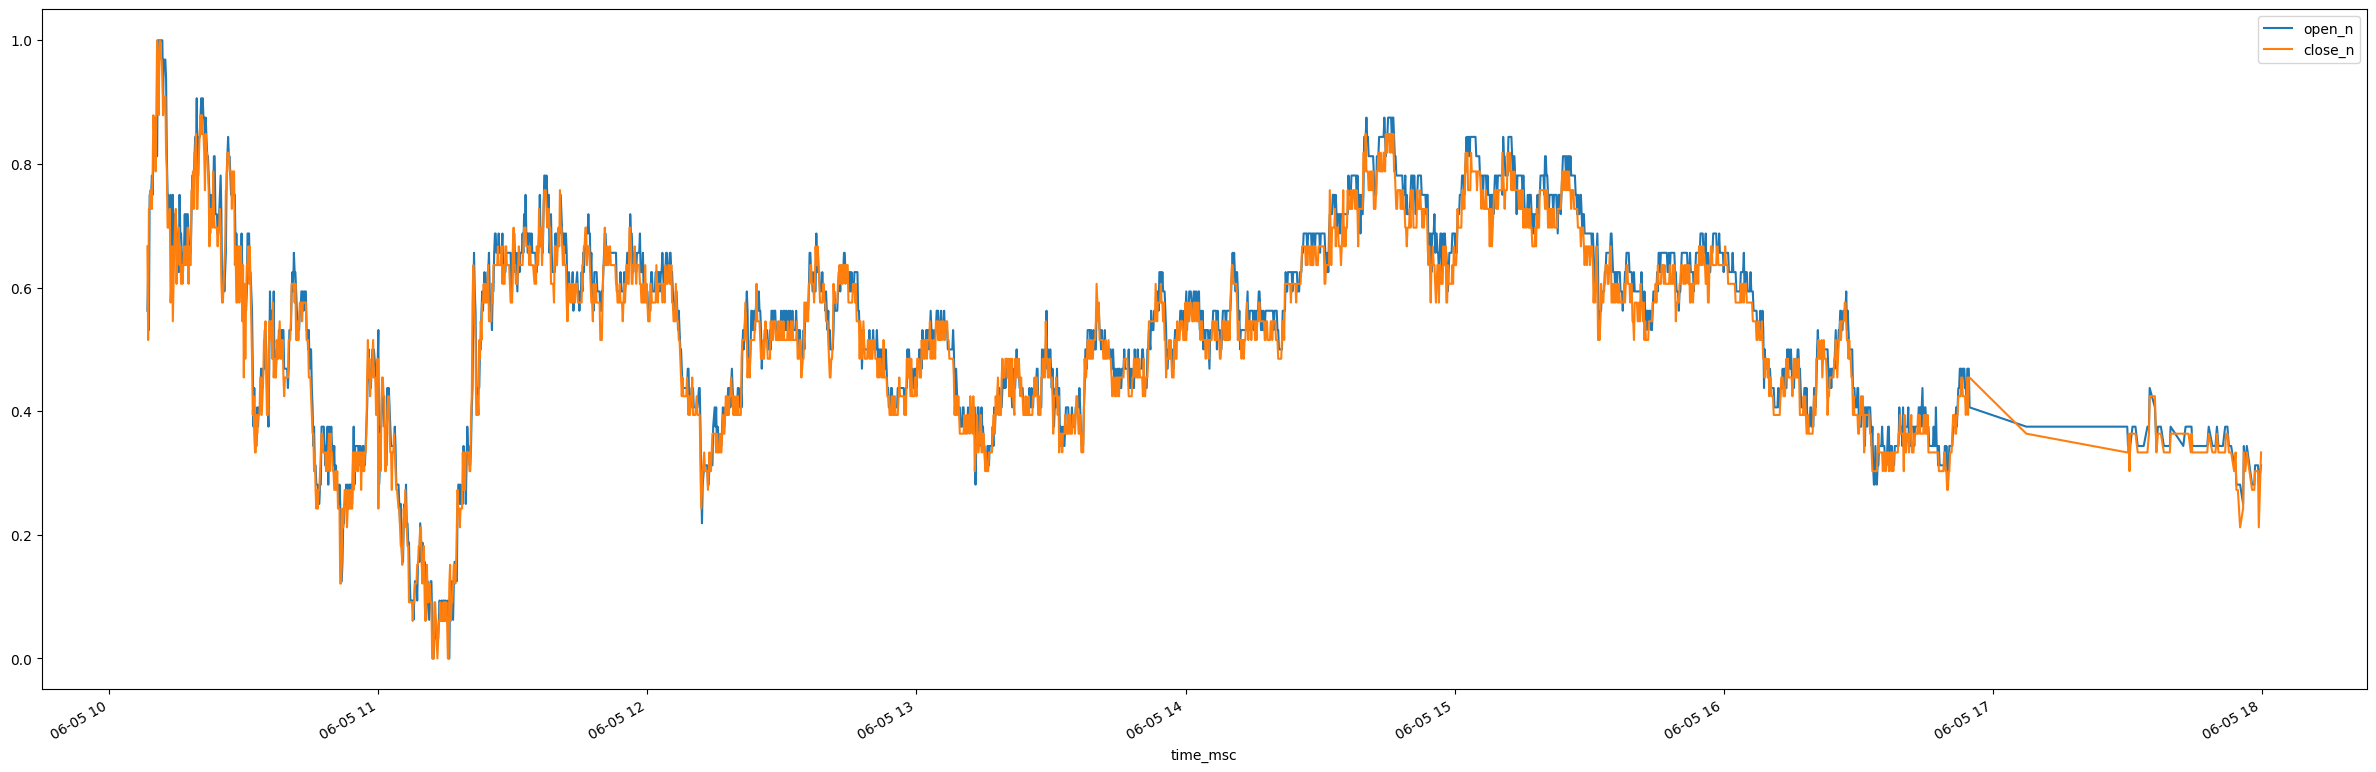

In [233]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

normalization = scaler.fit_transform(
    ratesjoin[["open", "close"]]
)

ratesjoin["open_n"] = normalization[:, 0]
ratesjoin["close_n"] = normalization[:, 1]

ratesjoin.to_excel("normalization.xlsx")

ratesjoin.iloc[:2500][["open_n", "close_n"]].plot(figsize=(30, 10))

In [247]:
n_len = 1500

train_data = ratesjoin.iloc[:n_len][["close_n", "open_n"]]
test_data = ratesjoin.iloc[n_len:][["close_n", "open_n"]]

n_features = 2

train_series = train_data.values.reshape((len(train_data), n_features))
test_series  = test_data.values.reshape((len(test_data), n_features))

In [248]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

look_back = 5

train_generator = TimeseriesGenerator(
    train_series,
    train_series[:, 0],  # close_n
    length=look_back,
    sampling_rate=1,
    stride=1,
    batch_size=10,
)

n_neurons = 5

model = Sequential()
model.add(LSTM(n_neurons, input_shape=(look_back, n_features)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

model.fit(train_generator, epochs=100)

Epoch 1/100
150/150 [==============================] - 1s 2ms/step - loss: 0.0648
Epoch 2/100
150/150 [==============================] - 0s 2ms/step - loss: 0.0081
Epoch 3/100
150/150 [==============================] - 0s 2ms/step - loss: 0.0057
Epoch 4/100
150/150 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 5/100
150/150 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 6/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 7/100
150/150 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 8/100
150/150 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 9/100
150/150 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 10/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 11/100
150/150 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 12/100
150/150 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 13/100


In [249]:
test_generator = TimeseriesGenerator(
    test_series,
    test_series[:, 0],  # close_n
    length=look_back,
    sampling_rate=1,
    stride=1,
    batch_size=10,
)

test_predictions = model.predict(test_generator)

98/98 [==============================] - 0s 842us/step


<Axes: xlabel='time_msc'>

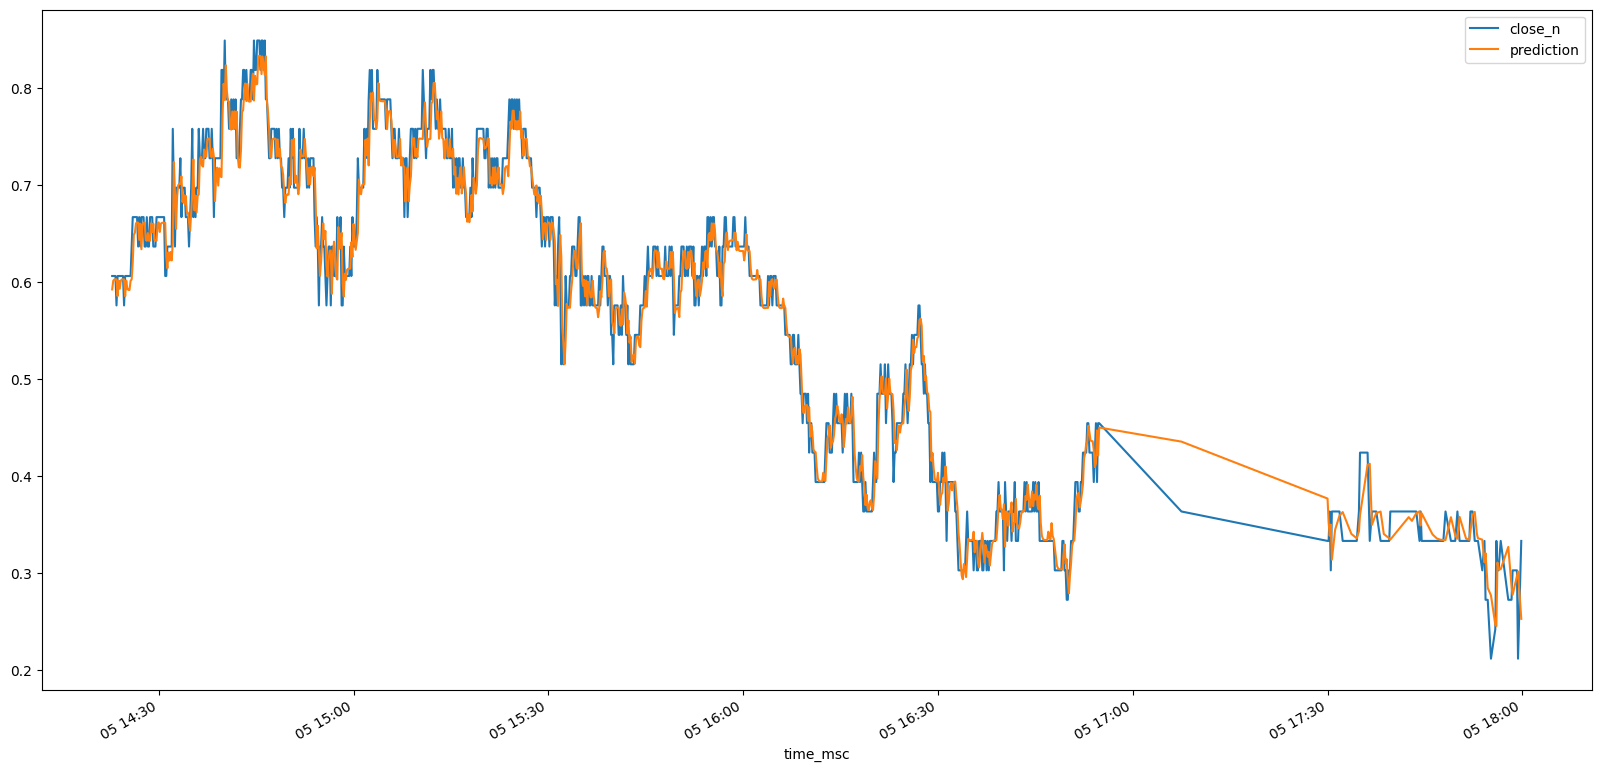

In [250]:
test_prediction = pd.DataFrame(test_data[look_back:])
test_prediction["prediction"] = test_predictions
test_prediction.iloc[:][["close_n", "prediction"]].plot(figsize=(20,10))

In [258]:
backtest = ratesjoin[(n_len + look_back):].copy()

backtest["prediction"] = test_predictions
backtest["entry"] = 0
backtest["exit"] = 0

backtest.loc[backtest["prediction"] > backtest["open_n"], "entry"] = 1
backtest.loc[backtest["prediction"] < backtest["open_n"], "exit"] = 1

backtest

,open,high,low,close,tick_volume,real_volume,vwap,open_n,high_n,low_n,close_n,vwap_n,prediction,entry,exit
time_msc,,,,,,,,,,,,,,,
2024-06-05 14:22:50,38.28,38.28,38.27,38.28,5,500,38.255980,0.62500,0.606061,0.604330,0.606061,0.604330,0.592252,0,1
2024-06-05 14:23:00,38.28,38.28,38.27,38.28,18,3200,38.256693,0.62500,0.606061,0.606963,0.606061,0.606963,0.601173,0,1
2024-06-05 14:23:10,38.28,38.28,38.28,38.28,4,600,38.256813,0.62500,0.606061,0.607407,0.606061,0.607407,0.602456,0,1
2024-06-05 14:23:20,38.28,38.28,38.27,38.28,8,900,38.257117,0.62500,0.606061,0.608530,0.606061,0.608530,0.602670,0,1
2024-06-05 14:23:30,38.28,38.28,38.27,38.27,4,500,38.257295,0.62500,0.575758,0.609188,0.575758,0.609188,0.602629,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-05 17:58:20,38.17,38.17,38.17,38.17,1,100,38.172390,0.28125,0.272727,0.295641,0.272727,0.295641,0.286606,1,0
2024-06-05 17:58:30,38.18,38.18,38.18,38.18,2,1000,38.172840,0.31250,0.303030,0.297304,0.303030,0.297304,0.277889,0,1
2024-06-05 17:59:10,38.18,38.18,38.18,38.18,1,100,38.171172,0.31250,0.303030,0.291144,0.303030,0.291144,0.297448,0,1


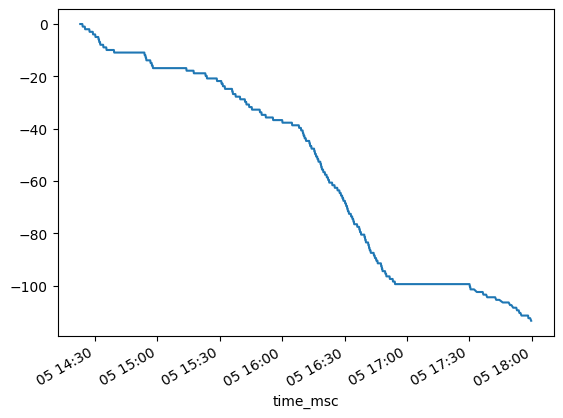

In [259]:
backtest["buy_price"] = np.nan
backtest["sell_price"] = np.nan
backtest["position_profit"] = 0
backtest["close_profit"] = 0
backtest["profit"] = 0

position = 0
position_profit = 0

take_profit = 100000
stop_loss = -100000

for i, item in backtest.iterrows():
    if position == 0:
        if item.entry == 1:
            backtest.loc[i, "buy_price"] = buy_price = item.open + slippage
            position = 1
        elif item.entry == -1:
            backtest.loc[i, "sell_price"] = sell_price = item.open - slippage
            position = -1
    elif position == 1:
        sell_price = item.open - slippage
        position_profit = sell_price - buy_price
        backtest.loc[i, "position_profit"] = position_profit
        if item.exit or item.entry == -1 or position_profit >= take_profit or position_profit <= stop_loss:
            backtest.loc[i, "sell_price"] = sell_price
            backtest.loc[i, "close_profit"] = position_profit
            position = 0      
    elif position == -1:
        buy_price = item.open + slippage
        position_profit = sell_price - buy_price
        backtest.loc[i, "position_profit"] = position_profit
        if item.exit or item.entry == 1 or position_profit >= take_profit or position_profit <= stop_loss:
            backtest.loc[i, "buy_price"] = buy_price = item.open + slippage
            backtest.loc[i, "close_profit"] = sell_price - buy_price
            position = 0
            

backtest["profit"] = backtest["close_profit"].cumsum()
backtest["profit"].plot()

backtest.to_excel("output_result.xlsx")